In [69]:
#importing libraries

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow
import librosa.display

In [115]:
def get_features(y,sr):

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    features=[np.mean(chroma_stft),np.mean(rmse),np.mean(spec_bw),np.mean(spec_cent),np.mean(rolloff),np.mean(zcr)]
    for e in mfcc:
        features.append(np.mean(e))
        
    return features

In [218]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    
    for filename in os.listdir(f'../input/gtzan-genre-collection/genres/{genre}'):
        songname = f'../input/gtzan-genre-collection/genres/{genre}/{filename}'
        for index in range(14):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*2)
#         y, sr = librosa.load(songname, mono=True,duration=3)
            features=get_features(y,sr)
            dataset.append((features,genre_number))



In [219]:
len(dataset)

14000

In [220]:
import random

random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

X_train, y_train = zip(*train)
X_val, y_val = zip(*valid)
X_test, y_test = zip(*test)


In [221]:
X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

X_train.shape


(10000, 26)

In [222]:
y_train.shape

(10000,)

In [223]:
import sklearn.preprocessing as skp

scaler = skp.StandardScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)
X_train

array([[ 2.30515562, -0.97350008,  1.18907174, ...,  0.32541447,
        -0.19237624,  0.88184896],
       [ 0.75969546,  0.94636066,  0.15954867, ...,  0.72713063,
        -0.62766927,  0.26149084],
       [ 0.57170288,  0.71329455, -0.15663904, ...,  0.42932957,
        -0.37350512, -0.23271861],
       ...,
       [ 0.39023563,  0.4502409 ,  2.00275708, ...,  0.45162324,
         0.5669081 ,  0.02190179],
       [-1.00340227,  0.92790189,  0.67913736, ..., -0.78604337,
        -0.53316324, -1.81524563],
       [-1.20734481, -0.69556994, -1.06846538, ..., -0.93810898,
        -1.02633125, -2.71200399]])

In [224]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define the training dataset
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Assuming Y_train is a tensor of integer labels
X_valid_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_valid_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_valid_tensor, Y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Model(
  (fc1): Linear(in_features=26, out_features=512, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (dropout4): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)
[Epoch 1] train loss: 2.182, val loss: 2.102, train acc: 0.266, val acc: 0.329
[Epoch 2] train loss: 2.074, val loss: 2.015, train acc: 0.380, val acc: 0.440
[Epoch 3] train loss: 1.999, val loss: 1.981, train acc: 0.454, val acc: 0.479
[Epoch 4] train loss: 1.973, val loss: 1.957, train acc: 0.485, val acc: 0.501
[Epoch 5] train loss: 1.951, val loss: 1.942, train acc: 0.507, val acc: 0.520
[Epoch 6] train loss: 1.940, val loss: 1.938, train acc: 0.520, val acc: 0.522
[Epoch 7] train loss: 1.930, val lo

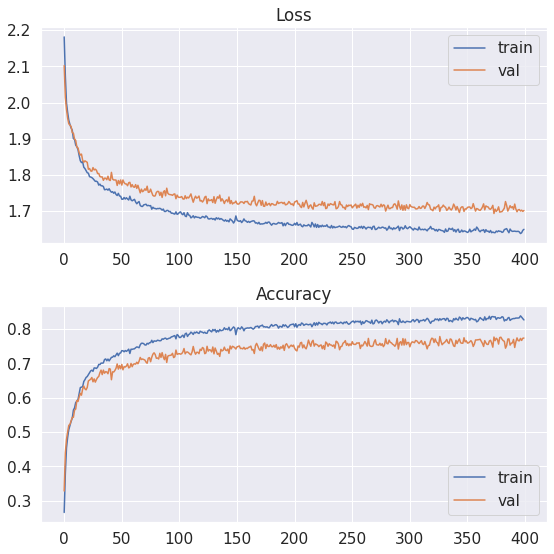

In [228]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 512)
        self.dropout1 = nn.Dropout(p=0.3)  # Add dropout after fc1
        self.fc2 = nn.Linear(512,256)
        self.dropout2 = nn.Dropout(p=0.2)  # Add dropout after fc2
        self.fc3 = nn.Linear(256,128)
        self.dropout3 = nn.Dropout(p=0.4)  # Add dropout after fc3
        self.fc4 = nn.Linear(128,64)
        self.dropout4 = nn.Dropout(p=0.4)  # Add dropout after fc3
        self.fc5 = nn.Linear(64, 10) 
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = torch.softmax(self.fc5(x), dim=1)
        return x
        
model = Model()
print(model)

optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.001)  # Change the learning rate to 0.001
loss_fn = nn.CrossEntropyLoss()

import matplotlib.pyplot as plt

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train_model(model, epochs):
    for epoch in range(epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0
        train_correct = 0
        val_correct = 0
        train_total = 0
        val_total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            train_loss = loss_fn(outputs, labels)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss = loss_fn(val_outputs, val_labels)
                running_val_loss += val_loss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (predicted == val_labels).sum().item()
        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_val_loss = running_val_loss / len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print('[Epoch %d] train loss: %.3f, val loss: %.3f, train acc: %.3f, val acc: %.3f' % (epoch + 1, epoch_train_loss, epoch_val_loss, train_acc, val_acc))
        
train_model(model, 400)

# Plot the training history
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_losses, label='train')
axs[0].plot(val_losses, label='val')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(train_accs, label='train')
axs[1].plot(val_accs, label='val')
axs[1].set_title('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()
ass

In [236]:
torch.save(model.state_dict(), "model.pth")


In [230]:
model.eval()

test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss += loss_fn(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_acc = test_correct / test_total

print('Test loss: %.3f, Test accuracy: %.3f' % (test_loss, test_acc))


Test loss: 1.666, Test accuracy: 0.800


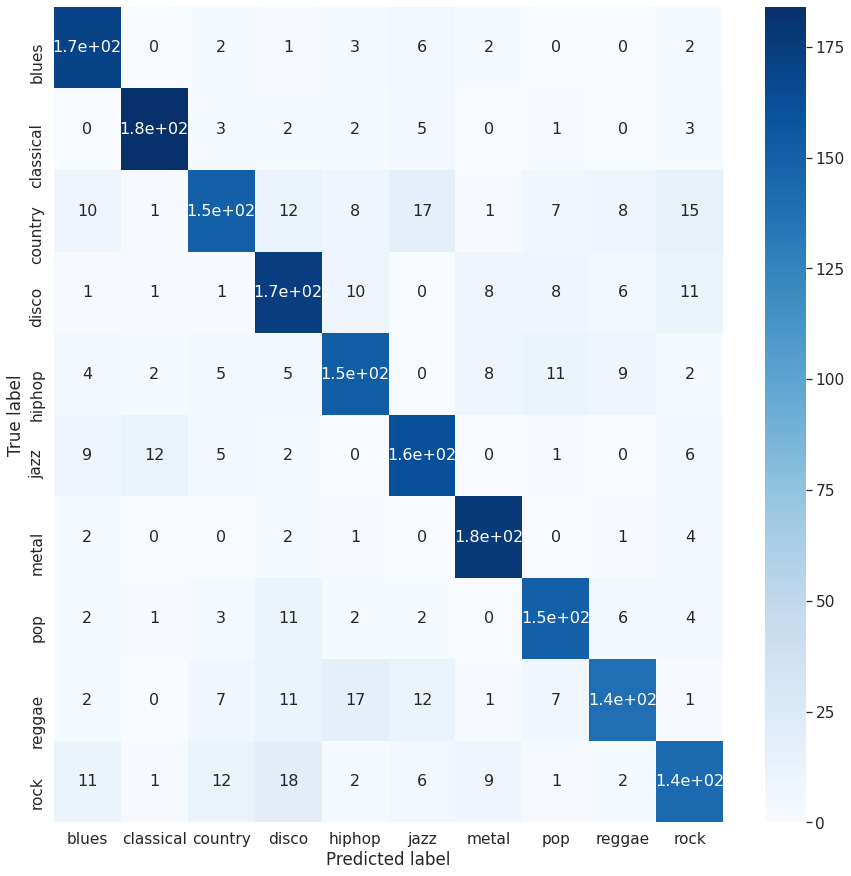

              precision    recall  f1-score   support

       blues       0.81      0.91      0.86       187
   classical       0.91      0.92      0.92       200
     country       0.80      0.66      0.72       229
       disco       0.73      0.79      0.76       220
      hiphop       0.77      0.77      0.77       197
        jazz       0.77      0.82      0.80       197
       metal       0.86      0.95      0.90       187
         pop       0.81      0.83      0.82       181
      reggae       0.81      0.71      0.76       197
        rock       0.75      0.70      0.72       205

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



In [235]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the predictions on the test set
y_pred = model(X_test_tensor).argmax(dim=1)

# Get the class labels as a list
class_names = list(genres.keys())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4) # for label size
fig, ax = plt.subplots(figsize=(15, 15))
# Plot the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', xticklabels=class_names, yticklabels=class_names) # font size
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred, target_names=class_names))
